In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import xray as xr
import xgcm
import os

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


In [2]:
ddir = '/data/scratch/rpa/paul_holland_model/paul'

ds = xr.open_dataset(os.path.join(ddir, 'grid.glob.nc'))

for fname in ['state2D-fixed.nc', 'stateExf-fixed.nc',]:
              #'stateTheta-fixed.nc', 'stateSalt-fixed.nc']:
    ds_new = xr.open_dataset(os.path.join(ddir, fname))
    # check if we need to select the top point of a 3D dataset
    if 'DEPTH' in ds_new:
        ds_new = ds_new.sel(DEPTH=5.0)
        ds_new = ds_new.drop('DEPTH')
    # state is 32 bit while grid is 64 bit
    # we can make merging easier by giving them the same coords
    ds_new['X'] = ds.X
    ds_new['Y'] = ds.Y
    ds = ds.merge(ds_new)

In [3]:
ds = ds.rename({'TIME':'time'})
ds

<xray.Dataset>
Dimensions:   (X: 1440, Xp1: 1440, Y: 640, Yp1: 640, Z: 50, Zl: 50, Zp1: 51, Zu: 50, time: 493)
Coordinates:
  * X         (X) float64 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * Y         (Y) float64 -85.91 -85.89 -85.88 -85.86 -85.84 -85.82 -85.8 ...
  * Xp1       (Xp1) float64 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5 ...
  * Yp1       (Yp1) float64 -85.92 -85.9 -85.88 -85.87 -85.85 -85.83 -85.81 ...
  * Z         (Z) float64 -5.0 -15.0 -25.0 -35.0 -45.0 -55.0 -65.0 -75.0 ...
  * Zp1       (Zp1) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
  * Zu        (Zu) float64 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 -80.01 ...
  * Zl        (Zl) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
  * time      (time) datetime64[ns] 1971-02-01 1971-03-01 1971-04-01 ...
Data variables:
    Depth     (Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    dxC       (Y, Xp1) float64 1.982e+03 1.982e+03 1.982e+03 1.982e+03 ...
  

In [4]:
ds_month = ds.groupby('time.month').mean(dim='time')
ds_freeze = ds_month.sel(month=slice(3,11)).mean(dim='month')
ds_freeze

<xray.Dataset>
Dimensions:   (X: 1440, Xp1: 1440, Y: 640, Yp1: 640, Z: 50, Zl: 50, Zp1: 51, Zu: 50)
Coordinates:
  * X         (X) float64 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * Y         (Y) float64 -85.91 -85.89 -85.88 -85.86 -85.84 -85.82 -85.8 ...
  * Xp1       (Xp1) float64 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5 ...
  * Yp1       (Yp1) float64 -85.92 -85.9 -85.88 -85.87 -85.85 -85.83 -85.81 ...
  * Z         (Z) float64 -5.0 -15.0 -25.0 -35.0 -45.0 -55.0 -65.0 -75.0 ...
  * Zp1       (Zp1) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
  * Zu        (Zu) float64 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 -80.01 ...
  * Zl        (Zl) float64 0.0 -10.0 -20.0 -30.0 -40.0 -50.0 -60.0 -70.0 ...
Data variables:
    SIqsw     (Y, X) float32 -39.1605 -39.1666 -39.1728 -39.1789 -39.185 ...
    EXFlwdn   (Y, X) float32 95.0378 94.9706 94.9036 94.8365 94.7694 94.7023 ...
    oceFWflx  (Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
   

In [5]:
from mpl_toolkits.basemap import Basemap
def southern_ocean_pcolormesh(lon, lat, data, boundinglat=-65, lw=0.25,
                              ax=None, labels=[1,1,0,1], **kwargs):
    """Plot something in the southern ocean."""
    
    m = Basemap(projection='spstere',boundinglat=boundinglat,lon_0=180, ax=ax)
    #m.drawcoastlines()
    m.fillcontinents(color='0.5',lake_color='0.55')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,5.), linewidth=lw)
    m.drawmeridians(np.arange(-180.,181.,20.), labels=labels, linewidth=lw)
    m.drawmapboundary(fill_color='w')
    #x, y = m(nc.variables['TLON'][:], nc.variables['TLAT'][:])
    return m.pcolormesh(lon, lat, data, latlon=True, **kwargs), m

def southern_ocean_contourf(lon, lat, data, clevs, boundinglat=-65, lw=0.25, 
                            ax=None, labels=[1,1,0,1], land=True, **kwargs):
    """Plot something in the southern ocean."""
    
    m = Basemap(projection='spstere',boundinglat=boundinglat,lon_0=180, ax=ax)
    #m.drawcoastlines()
    if land:
        m.fillcontinents(color='0.5',lake_color='0.55')
    else:
        m.drawcoastlines()
    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,5.), linewidth=lw)
    m.drawmeridians(np.arange(-180.,181.,20.), labels=labels, linewidth=lw)
    m.drawmapboundary(fill_color='w')
    #x, y = m(nc.variables['TLON'][:], nc.variables['TLAT'][:])
    return m.contourf(lon, lat, data, clevs, latlon=True, **kwargs), m



In [11]:
year = 24*60*60*365
lon, lat = np.meshgrid(ds.X.values, ds.Y.values)
plt.rcParams['font.size'] = 12

AttributeError: 'Dataset' object has no attribute 'SIdHbATC'

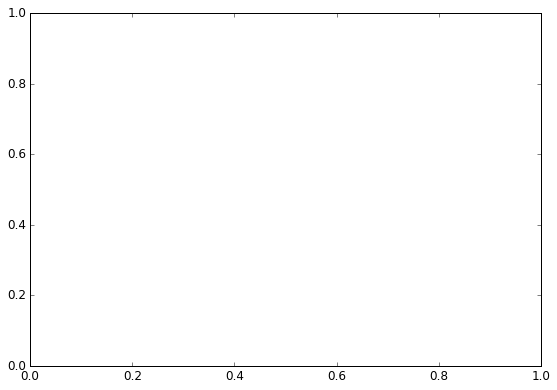

In [13]:

fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.2, wspace=0.03)

ax = fig.add_subplot(121)
pc, bm = southern_ocean_contourf(lon, lat, (year*ds_freeze.SIdHbATC), 
                                 np.arange(-16,17),
                                 labels=[0,1,0,1],
                               ax=ax, extend='both', cmap='RdBu_r')
ax.set_title('Ice Production by Atmospheric Heat Flux')

ax = fig.add_subplot(122)
pc, bm = southern_ocean_contourf(lon, lat, year*(ds_freeze.SIdHbATC + ds_freeze.SIdHbOCN), 
                                 np.arange(-16,17),
                                 labels=[1,0,0,1],
                               ax=ax, extend='both', cmap='RdBu_r')
ax.set_title('Ice Production by Atmospheric and Oceanic Heat Flux')

cb = fig.colorbar(pc)

cb.set_label('m/year')

In [8]:
SIempmr_mean = ds_month.SIempmr.mean(dim='month')
SIatmFW_mean = ds_month.SIatmFW.mean(dim='month')

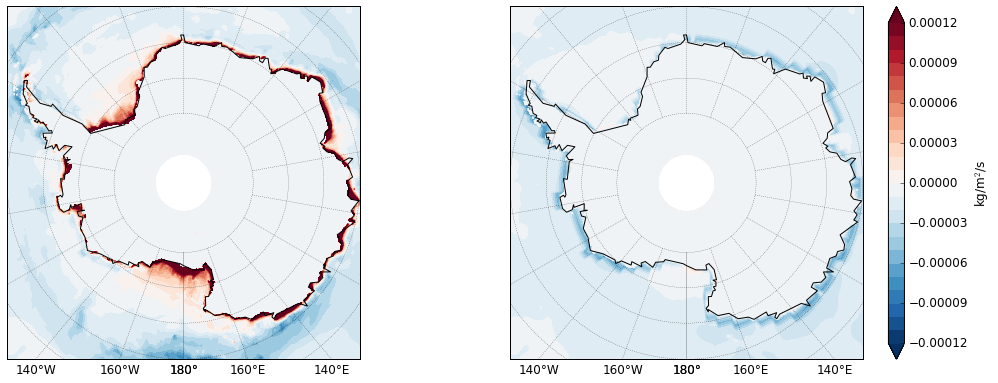

In [12]:
fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.2, wspace=0.03)

ax = fig.add_subplot(121)
pc, bm = southern_ocean_contourf(lon, lat, SIempmr_mean,
                                 np.arange(-12,13)*1e-5,
                                 labels=[0,0,0,1], land=False,
                               ax=ax, extend='both', cmap='RdBu_r')

#plt.title(ds.SIempmr.attrs['description'])

ax = fig.add_subplot(122)
pc, bm = southern_ocean_contourf(lon, lat, -SIatmFW_mean,
                                 np.arange(-12,13)*1e-5,
                                 labels=[0,0,0,1], land=False,
                               ax=ax, extend='both', cmap='RdBu_r')

#plt.title(ds.SIatmFW.attrs['description'])
cb = fig.colorbar(pc)
cb.set_label(r'kg/m$^2$/s')

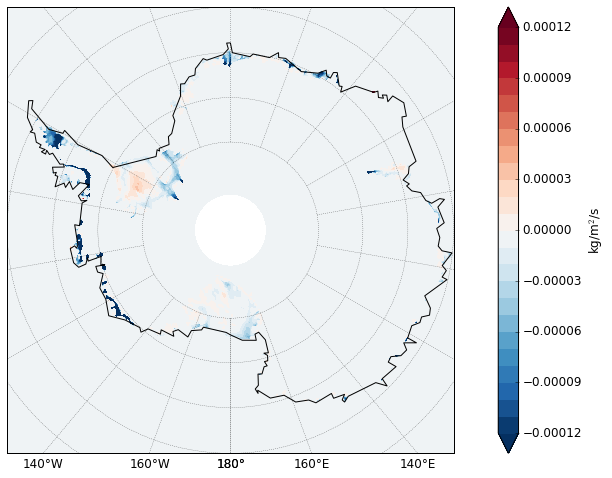

In [14]:

fig, ax = plt.subplots()
pc, bm = southern_ocean_contourf(lon, lat, ds_month.SHIfwFlx.mean(dim='month'),
                                 np.arange(-12,13)*1e-5,
                                 labels=[0,0,0,1], land=False,
                               ax=ax, extend='both', cmap='RdBu_r')

#plt.title(ds.SIatmFW.attrs['description'])
cb = fig.colorbar(pc)
cb.set_label(r'kg/m$^2$/s')

In [20]:
SFLUX_annmean = ds.SFLUX.mean(dim='time').load()

In [44]:
ds_TS = xr.open_dataset(os.path.join(ddir,'stateTheta-fixed.nc'))
#, 'stateSalt-fixed.nc']
ds_TS = ds_TS.merge(xr.open_dataset(os.path.join(ddir,'stateSalt-fixed.nc')))
ds_TS = ds_TS.rename({'DEPTH':'Z'})
ds_TS

<xray.Dataset>
Dimensions:  (TIME: 493, X: 1440, Y: 640, Z: 50)
Coordinates:
  * X        (X) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * Y        (Y) float32 -85.9111 -85.8933 -85.8754 -85.8574 -85.8393 ...
  * Z        (Z) float32 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.005 85.025 ...
  * TIME     (TIME) datetime64[ns] 1971-02-01 1971-03-01 1971-04-01 ...
Data variables:
    THETA    (TIME, Z, Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SALT     (TIME, Z, Y, X) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    history: Mon Mar 21 11:54:40 2016: ncrename -d LONGITUDE,X -d LATITUDE,Y -v LONGITUDE,X -v LATITUDE,Y stateTheta-tmp.nc stateTheta-fixed.nc
Mon Mar 21 11:39:56 2016: ncap2 -s LONGITUDE=LONGITUDE(0,:); LATITUDE=LATITUDE(:,0); stateTheta.nc stateTheta-tmp.nc
    nco_openmp_thread_number: 1

In [45]:
th_mean = ds_TS.THETA.mean(dim='TIME')

In [46]:
salt_mean = ds_TS.SALT.mean(dim='TIME')

In [47]:
mask = (ds.HFacC.values == 0.)
botmask = ~mask[:-1] & (mask[1:])
botmask = np.pad(botmask, ((0,1),(0,0),(0,0)), mode='constant')

In [48]:
th_bot = th_mean.where(botmask).mean(dim='Z')
salt_bot = salt_mean.where(botmask).mean(dim='Z')

th0_bot = ds_TS.THETA[0].where(botmask).mean(dim='Z')
salt0_bot = ds_TS.SALT[0].where(botmask).mean(dim='Z')

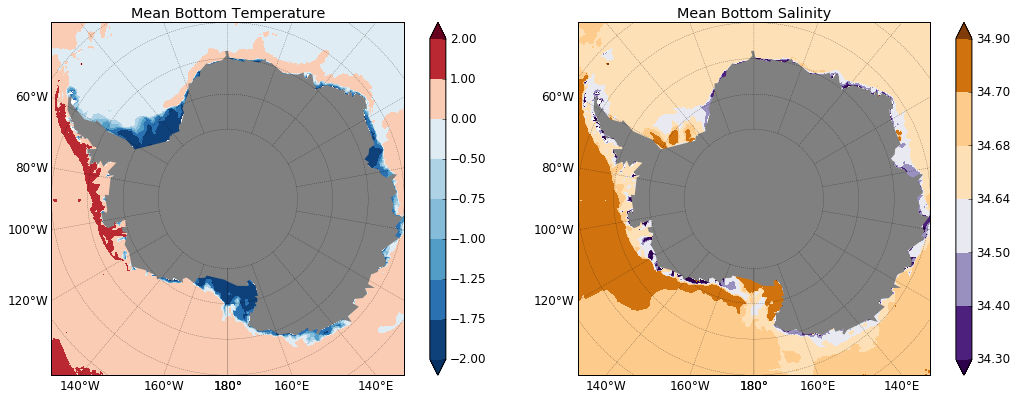

In [61]:
fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.2, wspace=0.03)

ax = fig.add_subplot(121)
pc, bm = southern_ocean_contourf(lon, lat, th_bot, 
                                 [-2,-1.75,-1.25,-1,-0.75,-0.5,0,1,2],
                                 labels=[1,0,0,1],
                               ax=ax, extend='both', cmap='RdBu_r')
plt.colorbar(pc)
plt.title('Mean Bottom Temperature')

ax = fig.add_subplot(122)
pc, bm = southern_ocean_contourf(lon, lat, salt_bot, 
                                 [34.3,34.4,34.5,34.64,34.68,34.7,34.9],
                                 labels=[1,0,0,1],
                               ax=ax, extend='both', cmap='PuOr_r')
plt.colorbar(pc)
plt.title('Mean Bottom Salinity')


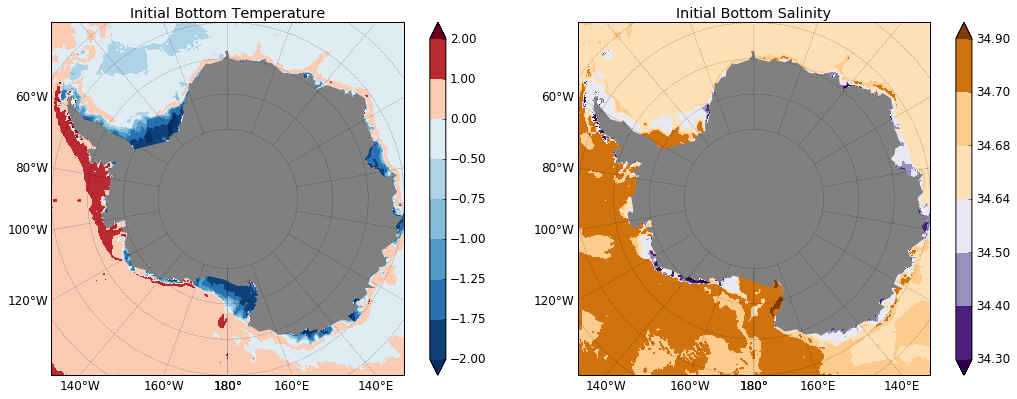

In [62]:
fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.2, wspace=0.03)

ax = fig.add_subplot(121)
pc, bm = southern_ocean_contourf(lon, lat, th0_bot, 
                                 [-2,-1.75,-1.25,-1,-0.75,-0.5,0,1,2],
                                 labels=[1,0,0,1],
                               ax=ax, extend='both', cmap='RdBu_r')
plt.colorbar(pc)
plt.title('Initial Bottom Temperature')

ax = fig.add_subplot(122)
pc, bm = southern_ocean_contourf(lon, lat, salt0_bot, 
                                 [34.3,34.4,34.5,34.64,34.68,34.7,34.9],
                                 labels=[1,0,0,1],
                               ax=ax, extend='both', cmap='PuOr_r')
plt.colorbar(pc)
plt.title('Initial Bottom Salinity')


In [52]:
#point = ds_TS.sel_points(X=[305], Y=[-73], method='nearest')
point = ds_TS.sel(X=300, method='nearest').sel(Y=-75, method='nearest')
point_flux = ds.sel(X=300, method='nearest').sel(Y=-75, method='nearest')

In [58]:
point.THETA

<xray.DataArray 'THETA' (TIME: 493, Z: 50)>
array([[ 0.74022418,  0.4577024 ,  0.09173842, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.86307395,  0.8324936 ,  0.72925121, ...,  0.        ,
         0.        ,  0.        ],
       [-1.40063369, -1.39696932, -1.397138  , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-1.90938032, -1.90320349, -1.90340304, ...,  0.        ,
         0.        ,  0.        ],
       [-1.89088476, -1.8537755 , -1.86249757, ...,  0.        ,
         0.        ,  0.        ],
       [-1.8423928 , -1.74720228, -1.72480321, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)
Coordinates:
    X        float32 300.125
    Y        float32 -74.9837
  * Z        (Z) float32 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.005 85.025 ...
  * TIME     (TIME) datetime64[ns] 1971-02-01 1971-03-01 1971-04-01 ...

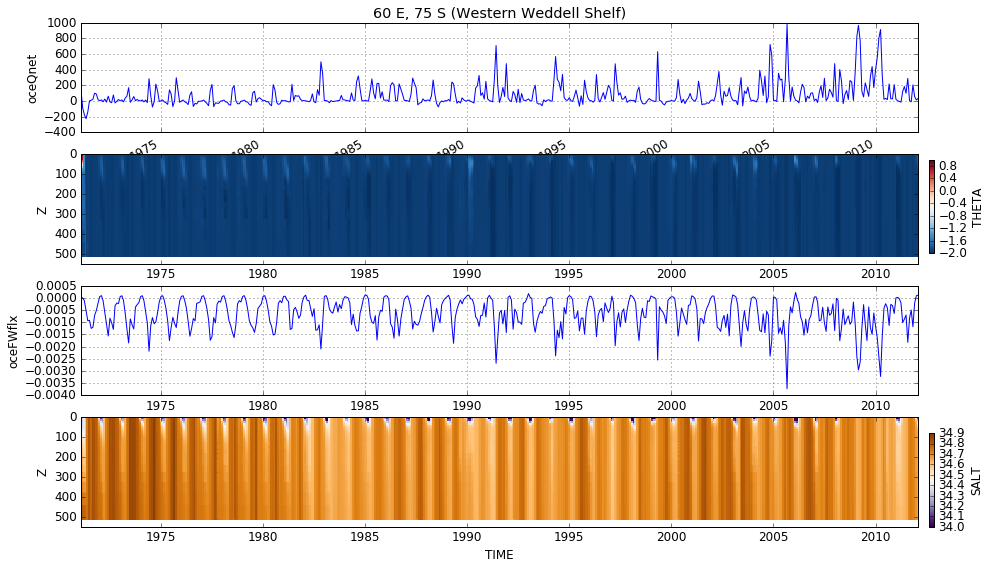

In [63]:
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(411)
point_flux.oceQnet.plot()
plt.xlim([point_flux.time[0].values, point_flux.time[-1].values])
plt.grid()
plt.title('60 E, 75 S (Western Weddell Shelf)')

ax2= plt.subplot(412)
pc1 = point.THETA.sel(Z=slice(0,550)).T.plot(vmin=-2,vmax=1, cmap='RdBu_r', add_colorbar=False)
ax2.set_xlim([point_flux.time[0].values, point_flux.time[-1].values])
ax2.set_ylim([550,0])
plt.title('')
cb1 = plt.colorbar(pc1, cax=plt.axes([0.91,0.58,0.005,0.13]))
cb1.set_label('THETA')


#ax1.set_position(Bbox([nb[:2],nb[2:]]))
ax3= plt.subplot(413)
point_flux.oceFWflx.plot()
plt.xlim([point_flux.time[0].values, point_flux.time[-1].values])
plt.title('')
plt.grid()

ax4 = plt.subplot(414)
pc2 = point.SALT.sel(Z=slice(0,550)).T.plot(vmin=34,vmax=34.9,cmap='PuOr_r', add_colorbar=False)
ax4.set_ylim([550,0])
plt.title('')
plt.xlim([point_flux.time[0].values, point_flux.time[-1].values])
cb2 = plt.colorbar(pc2, cax=plt.axes([0.91,0.2,0.005,0.13]))
cb2.set_label('SALT')


In [16]:
heff_mean = ds_month.SIheff.mean(dim='month')
snow_mean = ds_month.SIhsnow.mean(dim='month')

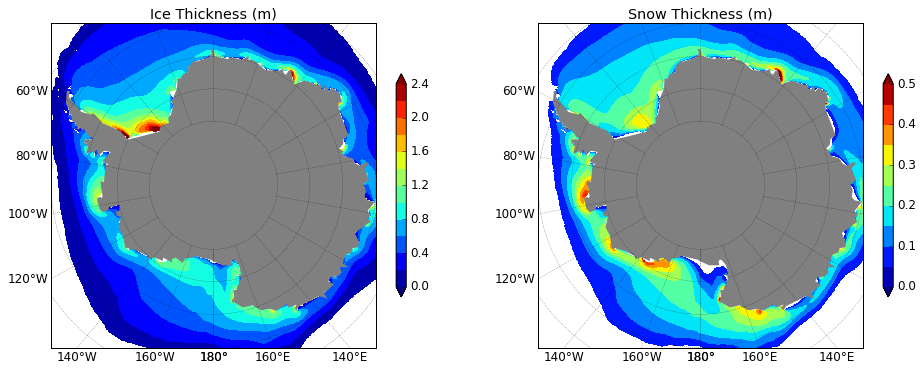

In [17]:
fig, [ax1, ax2] = plt.subplots(ncols=2)
pc, bm = southern_ocean_contourf(lon, lat, np.ma.masked_less(heff_mean,0.05), np.arange(0,2.5,0.2),
                                 labels=[1,0,0,1],
                               ax=ax1, extend='both', cmap='jet')
plt.colorbar(pc, ax=ax1, shrink=0.5)
ax1.set_title('Ice Thickness (m)')

pc, bm = southern_ocean_contourf(lon, lat, np.ma.masked_less(snow_mean,0.05), np.arange(0,.501,0.05),
                                 labels=[1,0,0,1],
                               ax=ax2, extend='both', cmap='jet')
plt.colorbar(pc, ax=ax2, shrink=0.5)
ax2.set_title('Snow Thickness (m)')



In [ ]:
ds.SI